# Sentiment Classification Project

In [ ]:
import importlib
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

import data_loader.data_loader
import data_preprocessing.data_preprocessing

# Reload the module to reflect changes
importlib.reload(data_loader.data_loader)
importlib.reload(data_preprocessing.data_preprocessing)

from data_loader.data_loader import *
from data_preprocessing.data_preprocessing import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize

#For Stemming text
from nltk.stem import PorterStemmer

import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer

#For evaluation of model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [1]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /Users/tnorlha/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


# Load data

In [3]:
training_df = load_training_data()
test_sents = load_test_data()

train_sents, val_sents, train_labels, val_labels = create_train_val_split(training_df)

print("Train size:", len(train_sents))
print("Validation size:", len(val_sents))

Train size: 91887
Validation size: 10210


# Baseline model with Bag-of-words + Logistic Regression

In [144]:
from sklearn.feature_extraction.text import CountVectorizer

# We only keep the 10'000 most frequent words and bigrams (i.e. word pairs)
# This is both to reduce the computational cost and reduce potential overfitting

vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

# An Example of another BoW Vectorizer
other_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=10000, min_df=10, max_df=0.9)

# Important: we call fit_transform on the training set, and only transform on the validation set
X_train = vectorizer.fit_transform(train_sents["sentence"])
X_val = vectorizer.transform(val_sents["sentence"])

Y_train = train_labels
Y_val = val_labels

In [145]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Classifier, C: Inverse of regularization strength , max_iter: Maximum number of training iterations
model = LogisticRegression(C=1.0, max_iter=100)
model.fit(X_train, Y_train)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
Y_train_pred = model.predict(X_train)
# Predict on Validation Set
Y_val_pred = model.predict(X_val)

In [8]:
from sklearn.metrics import mean_absolute_error

# Score on Training Set
mae_train = mean_absolute_error(Y_train, Y_train_pred)
L_score_train = 0.5 * (2 - mae_train)
# Score on Validation Set
mae_val = mean_absolute_error(Y_val, Y_val_pred)
L_score_val = 0.5 * (2 - mae_val)

In [9]:
print(f'Evaluation Score (training set): {L_score_train:.05f}')
print(f'Evaluation Score (validation set): {L_score_val:.05f}')

Evaluation Score (training set): 0.85408
Evaluation Score (validation set): 0.79922


# Better Preprocessing

# NLP approach

- Adding a few columns for more analysis of the dataset

In [67]:
train_analysis = nlp_analysis(train_sents)

In [68]:
print(f"Max word count: {train_analysis['word_counts'].max()}")
print(f"Min word count: {train_analysis['word_counts'].min()}")
print(f"Average word count: {train_analysis['word_counts'].mean()}")
print(f"Std word count: {train_analysis['word_counts'].std()}")

Max word count: 258
Min word count: 1
Average word count: 13.686560666906091
Std word count: 8.510937556532872


In [69]:
print(f"Max stop words: {train_analysis['stop_words_len'].max()}")

Max stop words: 125


In [70]:
print(f"Max numeric count: {train_analysis['numerics_count'].max()}")

Max numeric count: 12


In [71]:
print(f"Max upper count: {train_analysis['upper_counts'].max()}")

Max upper count: 26


- Doing a few preprocessing steps (read function definition for more information)

In [4]:
train_sents, val_sents, test_sents = nlp_preprocess_train_valid_test(train_sents, val_sents, test_sents)

# Analysis and Visualization

Word cloud visualization of the dataset

-> show words in varying sizes based on their frequency

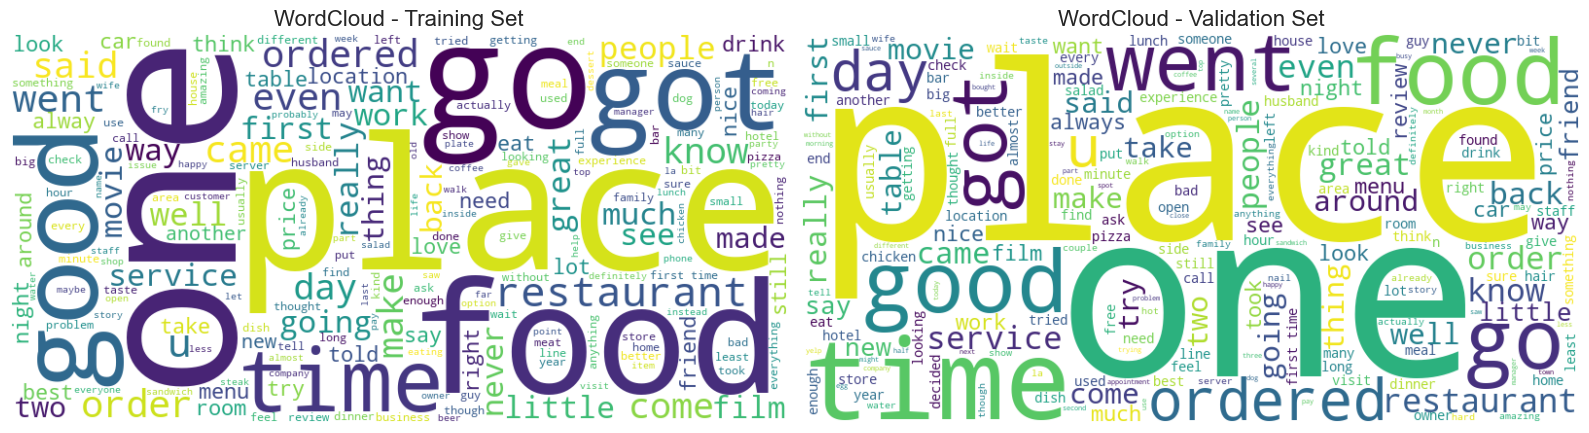

In [73]:
# Combine all sentences into one string for each dataset
text_from_train = ' '.join(train_sents['sentence'])
text_from_valid = ' '.join(val_sents['sentence'])

# Create WordCloud objects
wc_train = WordCloud(width=800, height=400, background_color='white').generate(text_from_train)
wc_valid = WordCloud(width=800, height=400, background_color='white').generate(text_from_valid)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(wc_train, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('WordCloud - Training Set', fontsize=16)

axes[1].imshow(wc_valid, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('WordCloud - Validation Set', fontsize=16)

plt.tight_layout()
plt.show()

## As a whole

In [74]:
# Lists to store words based on sentiment
negative_words = []
positive_words = []
neutral_words = []

words = text_from_train.split()


# Perform sentiment analysis for each word
for word in words:
    blob = TextBlob(word)

    # blob.sentiment.polarity is a feature provided by TextBlob that quantifies the sentiment of a text.
    # It calculates a numerical value that indicates whether the text is positive, negative, or neutral based on the arrangement of words and their emotional impact.
    sentiment_score = blob.sentiment.polarity
    words = blob.words

    # Categorize words based on sentiment score
    if sentiment_score < 0:
        negative_words.extend(words)
    elif sentiment_score > 0:
        positive_words.extend(words)
    else:
        neutral_words.extend(words)

print('negative_words', len(negative_words))
print('positive_words', len(positive_words))
print('neutral_words', len(neutral_words))

negative_words 27055
positive_words 57097
neutral_words 452578


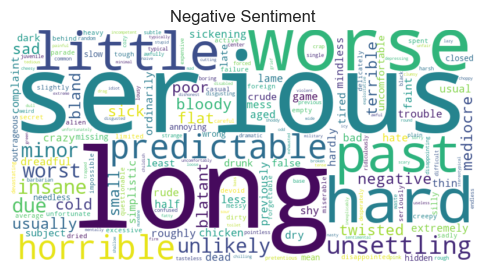

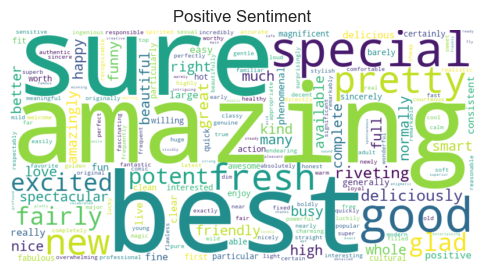

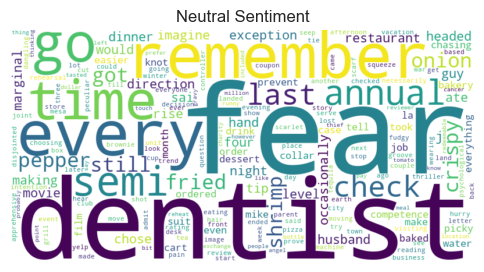

In [75]:
# Generate word cloud for negative words if available
if negative_words:
    negative_wordcloud = WordCloud(width=800, height=400, background_color='white')
    negative_wordcloud.generate_from_frequencies(dict(zip(negative_words, [1] * len(negative_words))))
    plt.figure(figsize=(6, 4))
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title("Negative Sentiment")
    plt.axis('off')
    plt.show()
else:
    print("No negative words available for word cloud.")

# Generate word cloud for positive words if available
if positive_words:
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white')
    positive_wordcloud.generate_from_frequencies(dict(zip(positive_words, [1] * len(positive_words))))
    plt.figure(figsize=(6, 4))
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title("Positive Sentiment")
    plt.axis('off')
    plt.show()
else:
    print("No positive words available for word cloud.")

# Generate word cloud for neutral words if available
if neutral_words:
    neutral_wordcloud = WordCloud(width=800, height=400, background_color='white')
    neutral_wordcloud.generate_from_frequencies(dict(zip(neutral_words, [1] * len(neutral_words))))
    plt.figure(figsize=(6, 4))
    plt.imshow(neutral_wordcloud, interpolation='bilinear')
    plt.title("Neutral Sentiment")
    plt.axis('off')
    plt.show()
else:
    print("No neutral words available for word cloud.")

## Samples individually

In [76]:
train_sentiment_df = {}
train_sentiment_df["sentence"] = train_sents["sentence"].copy()

In [77]:
# Performing Stemming
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [78]:
train_sentiment_df["sentence"] = train_sentiment_df["sentence"].apply(lambda x: stemming(x))

In [79]:
#visualizing Processed text
print(train_sentiment_df["sentence"].iloc[0],"\n")
print(train_sentiment_df["sentence"].iloc[1],"\n")

serious fear dentist long remember every time go semi annual check worse last time 

pepper onion shrimp fried still crispy got imagine amazing would ate restaurant 



In [80]:
train_sentiment_df['scores'] = train_sentiment_df['sentence'].apply(lambda review: sid.polarity_scores(review))

In [81]:
train_sentiment_df['compound']  = train_sentiment_df['scores'].apply(lambda score_dict: score_dict['compound'])

In [82]:
train_sentiment_df['comp_score'] = train_sentiment_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [83]:
#calculating polarity for categorizing text
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [84]:
train_sentiment_df["polarity"] = train_sentiment_df["sentence"].apply(polarity)

In [85]:
train_sentiment_df_list = pd.DataFrame(train_sentiment_df, columns=['sentence','polarity'])

In [86]:
#  Adding Sentiment to the data frame
def sentiment(label):
    if label <0:
        return "negative"
    elif label ==0:
        return "neutral"
    elif label>0:
        return "positive"

In [87]:
train_sentiment_df_list['sentiment'] = train_sentiment_df_list['polarity'].apply(sentiment)
train_sentiment_df_list.head(10)

,sentence,polarity,sentiment
id,,,
90962,serious fear dentist long remember every time ...,-0.195833,negative
28024,pepper onion shrimp fried still crispy got ima...,0.600000,positive
36538,guy making sai exception,0.000000,neutral
65857,husband headed movie night chose j,0.000000,neutral
7186,hand best,1.000000,positive
63012,dinner four tip,0.000000,neutral
53288,direction occasionally rise level marginal com...,-0.145833,negative
55101,even took collar past month make job easier pr...,-0.250000,negative
64743,drink sure order mike special,0.428571,positive


<Axes: xlabel='sentiment', ylabel='count'>

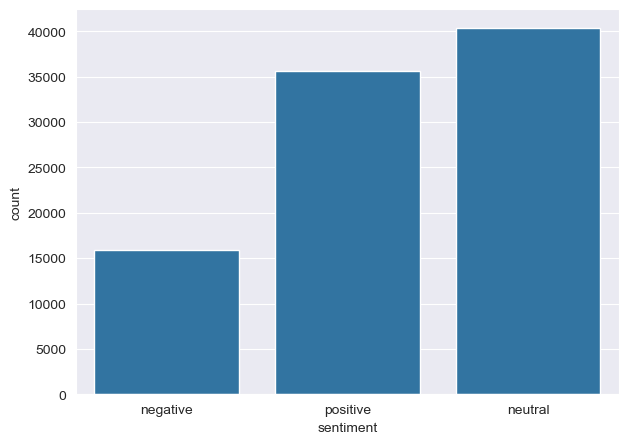

In [88]:
#Visualizing the Sentiment
fig = plt.figure(figsize=(7,5))
sns.countplot(x="sentiment",data=train_sentiment_df_list)

Text(0.5, 1.0, 'Distribution of sentiments')

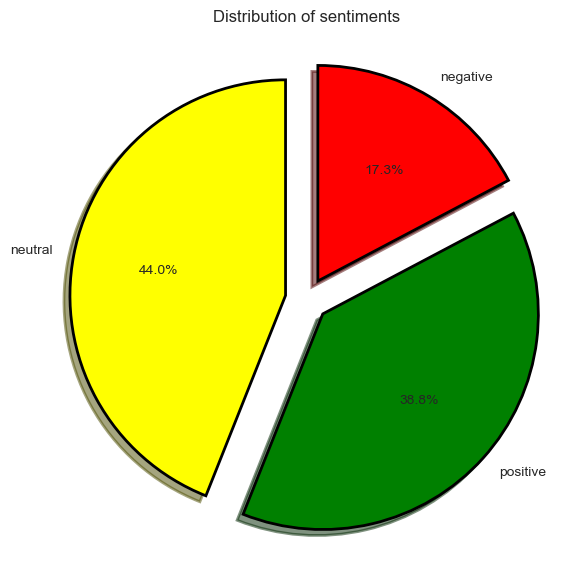

In [96]:
fig = plt.figure(figsize=(7,7))
colors = ("yellow", "green", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = train_sentiment_df_list['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [97]:
#Visulaizing Top 5 positive Sentiments
pos_samples = train_sentiment_df_list[train_sentiment_df_list.sentiment == 'positive']
pos_samples = pos_samples.sort_values(['polarity'], ascending= False)
pos_samples.head()

,sentence,polarity,sentiment,scores,compound,comp_score
id,,,,,,
48584,service excellent food amazed way,1.0,positive,"{'neg': 0.0, 'neu': 0.303, 'pos': 0.697, 'comp...",0.7845,Positive
65419,u menu pitching u restaurant best food best,1.0,positive,"{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'comp...",0.8555,Positive
98002,believe best intention n restraint fully realize,1.0,positive,"{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'comp...",0.6369,Positive
75560,previously excellent service wonderful gentleman,1.0,positive,"{'neg': 0.0, 'neu': 0.288, 'pos': 0.712, 'comp...",0.8126,Positive
95995,also vegetarian delicious alternative,1.0,positive,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719,Positive


Get the sentiment scores

In [98]:
train_sentiment_df_list['scores'] = train_sentiment_df_list['sentence'].apply(lambda review: sid.polarity_scores(review))

train_sentiment_df_list['compound']  = train_sentiment_df_list['scores'].apply(lambda score_dict: score_dict['compound'])

train_sentiment_df_list['comp_score'] = train_sentiment_df_list['compound'].apply(lambda c: 'positive' if c > 0 else ('neutral' if c == 0 else 'negative'))

train_sentiment_df_list.head()

,sentence,polarity,sentiment,scores,compound,comp_score
id,,,,,,
90962,serious fear dentist long remember every time ...,-0.195833,negative,"{'neg': 0.409, 'neu': 0.591, 'pos': 0.0, 'comp...",-0.7650,negative
28024,pepper onion shrimp fried still crispy got ima...,0.600000,positive,"{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'comp...",0.5859,positive
36538,guy making sai exception,0.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
65857,husband headed movie night chose j,0.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
7186,hand best,1.000000,positive,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.8126,positive


<Axes: xlabel='comp_score', ylabel='count'>

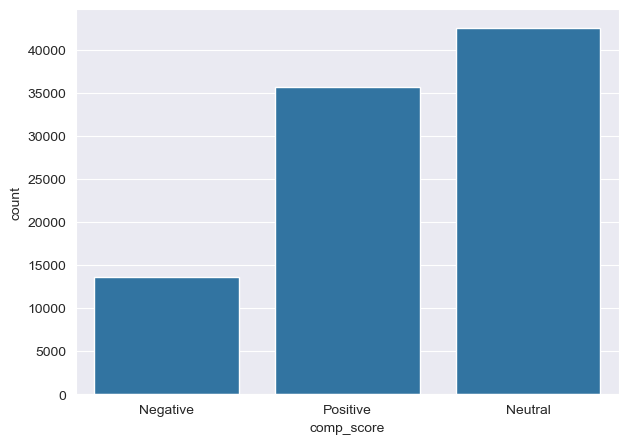

In [92]:
#Visualizing the Sentiment
fig = plt.figure(figsize=(7,5))
sns.countplot(x="comp_score",data=train_sentiment_df_list)

Text(0.5, 1.0, 'Distribution of sentiments comp_score')

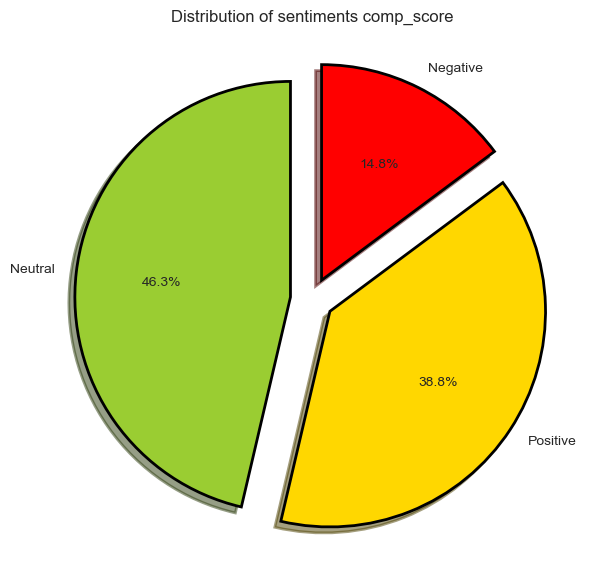

In [93]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = train_sentiment_df_list['comp_score'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments comp_score')

Compare Compound Score Sentiment Vs Sentiment Labels¶

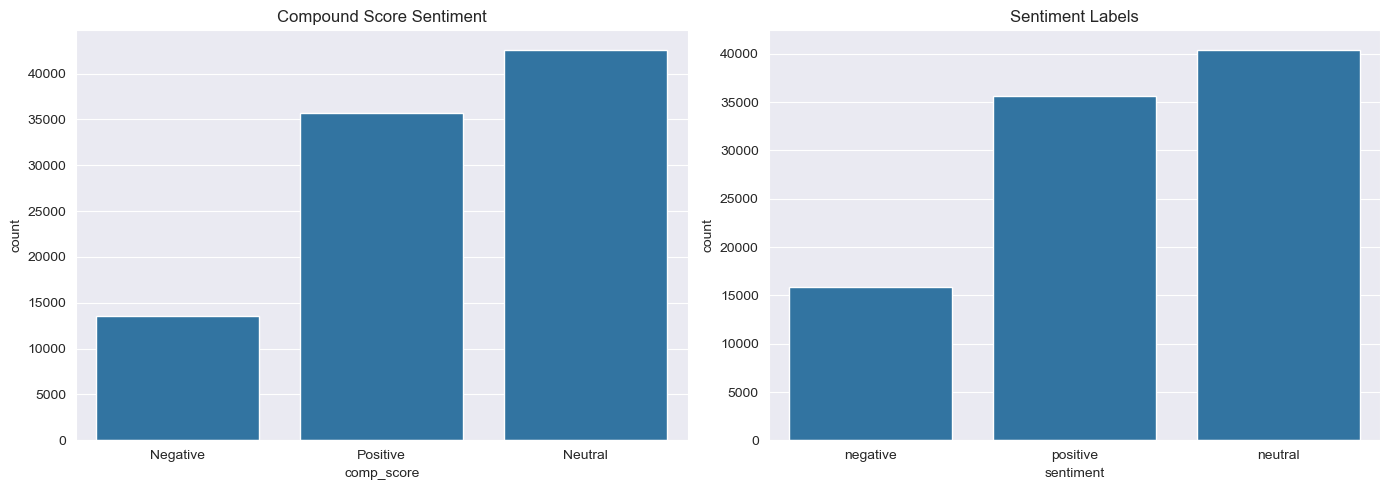

In [94]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First subplot for compound scores
sns.countplot(x="comp_score", data=train_sentiment_df_list, ax=axes[0])
axes[0].set_title('Compound Score Sentiment')

# Second subplot for sentiments
sns.countplot(x="sentiment", data=train_sentiment_df_list, ax=axes[1])
axes[1].set_title('Sentiment Labels')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

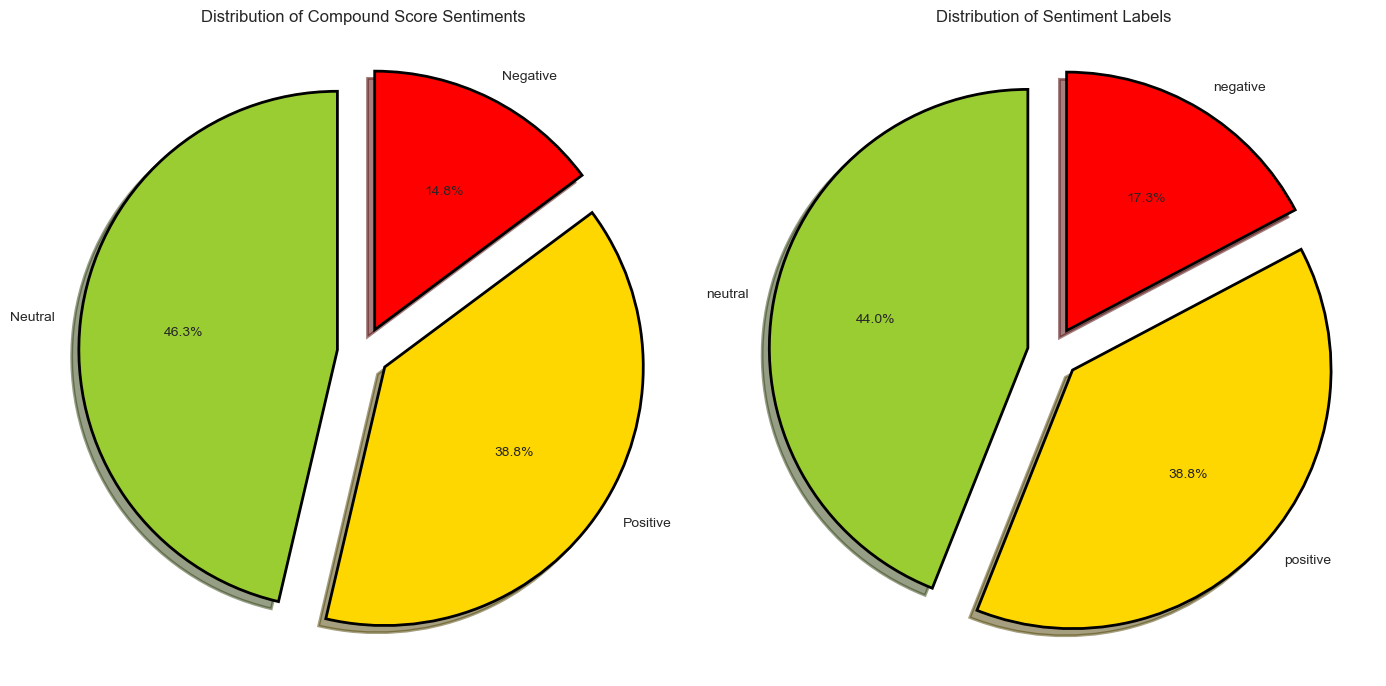

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# First subplot for compound score distribution
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth': 2, 'edgecolor': "black"}
tags_comp = train_sentiment_df_list['comp_score'].value_counts()
explode = (0.1, 0.1, 0.1)
tags_comp.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors,
               startangle=90, wedgeprops=wp, explode=explode, label='', ax=axes[0])
axes[0].set_title('Distribution of Compound Score Sentiments')

# Second subplot for sentiment label distribution
tags_sentiment = train_sentiment_df_list['sentiment'].value_counts()
tags_sentiment.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors,
                    startangle=90, wedgeprops=wp, explode=explode, label='', ax=axes[1])
axes[1].set_title('Distribution of Sentiment Labels')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [100]:
train_sentiment_df_list.head()

,sentence,polarity,sentiment,scores,compound,comp_score
id,,,,,,
90962,serious fear dentist long remember every time ...,-0.195833,negative,"{'neg': 0.409, 'neu': 0.591, 'pos': 0.0, 'comp...",-0.7650,negative
28024,pepper onion shrimp fried still crispy got ima...,0.600000,positive,"{'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'comp...",0.5859,positive
36538,guy making sai exception,0.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
65857,husband headed movie night chose j,0.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
7186,hand best,1.000000,positive,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.8126,positive


# Model Evaluation

In [6]:
# vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000) # max_features=10000

# # An Example of another BoW Vectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english', max_features=10000, min_df=10, max_df=0.9)

X_train = vectorizer.fit_transform(train_sents["sentence"])
X_val = vectorizer.transform(val_sents["sentence"])
X_test = vectorizer.transform(test_sents["sentence"])

Y_train = train_labels
Y_val = val_labels

In [177]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Classifier, C: Inverse of regularization strength , max_iter: Maximum number of training iterations
model = LogisticRegression(C=1.0, max_iter=100)
model.fit(X_train, Y_train)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [178]:
Y_train_pred = model.predict(X_train)
# Predict on Validation Set
Y_val_pred = model.predict(X_val)

from sklearn.metrics import mean_absolute_error

# Score on Training Set
mae_train = mean_absolute_error(Y_train, Y_train_pred)
L_score_train = 0.5 * (2 - mae_train)
# Score on Validation Set
mae_val = mean_absolute_error(Y_val, Y_val_pred)
L_score_val = 0.5 * (2 - mae_val)

print(f'Evaluation Score (training set): {L_score_train:.05f}')
print(f'Evaluation Score (validation set): {L_score_val:.05f}')

Evaluation Score (training set): 0.82507
Evaluation Score (validation set): 0.79153


Not good uhhh

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error

# Stacking ensemble using classifiers
best_classification_model = Pipeline([
    ('stacking classifier', StackingClassifier(
        estimators=[
            ("svc", SVC(C=60.0, gamma='auto', kernel='rbf', probability=True)),
            ("gbc", GradientBoostingClassifier(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=10,
                min_samples_leaf=40,
                random_state=42
            )),
            ("abc", AdaBoostClassifier(random_state=42)),
        ],
        final_estimator=LogisticRegression(max_iter=500),
        # passthrough=False,
        # cv=3,
        # n_jobs=-1
    ))
])

# Fit the model
best_classification_model.fit(X_train, Y_train)

# Predictions
Y_train_pred = best_classification_model.predict(X_train)
Y_val_pred = best_classification_model.predict(X_val)

# L_score
def L_score(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return 0.5 * (2 - mae)

train_score = L_score(Y_train, Y_train_pred)
val_score = L_score(Y_val, Y_val_pred)

print(f"Training L-score:   {train_score:.5f}")
print(f"Validation L-score: {val_score:.5f}")

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
